Module importing

In [4]:
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import scipy.signal as signal
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

sys.path.append('/workspace/my_DL_tool/model')
from autoencoder import Autoencoder
sys.path.append('/workspace/my_DL_tool/tool')
from ppg_signal_load import PPGDataset
from model_builder import k_fold_training
from performance import performance

Data prepairing

The total data points: 58085
(200,)


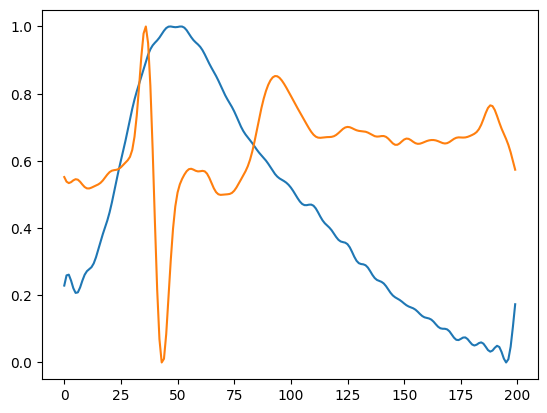

In [5]:
#Import_data
def preprocessing1(item):
    N = 200
    item[0] = signal.resample(item[0],N)
    item[1] = signal.resample(item[1],N)
    item[0] = (item[0]-np.min(item[0]))/(np.max(item[0])-np.min(item[0]))
    item[1] = (item[1]-np.min(item[1]))/(np.max(item[1])-np.min(item[1]))
    if len(item[0]) == len(item[1]):
        return item

def preprocessing2(item):
    N = 1000
    if len(item[0]) != 1000:
        item[0] = item[0][0:1000]
        item[0] = (item[0]-np.min(item[0]))/(np.max(item[0])-np.min(item[0]))
    if len(item[1]) != 1000:
        item[1] = item[1][0:1000]    
        item[1] = (item[1]-np.min(item[1]))/(np.max(item[1])-np.min(item[1]))
    
    return item

dataset = PPGDataset('/workspace/my_DL_tool/data/data.json',preprocessing = preprocessing1)
index = random.randint(0, len(dataset)-1)
z = dataset[0][0].numpy().flatten()
print(z.shape)
plt.plot(dataset[0][0].numpy().flatten())
plt.plot(dataset[0][1].numpy().flatten())
plt.show()

N = len(dataset)
test_len = int(N*0.2)
train_len = N-test_len

train_data, test_data = random_split(dataset, [train_len, test_len])

Training

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = Autoencoder(layer_dims = [200,200,200,200,100,100,100,50,50])
optimizer = optim.Adam(model.parameters(), lr=0.0001)
builder = k_fold_training(train_data,1,criterion = nn.L1Loss())
builder.training(model,device,optimizer,num_epochs=500,batch=128,visualize=1)

Iteration: 1/500. loss_train: 0.22166629766042417. loss_val: 0
Iteration: 2/500. loss_train: 0.21431934853995238. loss_val: 0
Iteration: 3/500. loss_train: 0.21469999182519023. loss_val: 0
Iteration: 4/500. loss_train: 0.21425808294788823. loss_val: 0
Iteration: 5/500. loss_train: 0.21223113681752603. loss_val: 0
Iteration: 6/500. loss_train: 0.20673633125293386. loss_val: 0
Iteration: 7/500. loss_train: 0.1984745647226061. loss_val: 0
Iteration: 8/500. loss_train: 0.19393816925994642. loss_val: 0
Iteration: 9/500. loss_train: 0.1915913976237669. loss_val: 0
Iteration: 10/500. loss_train: 0.19063201992885098. loss_val: 0
Iteration: 11/500. loss_train: 0.18857809168460604. loss_val: 0
Iteration: 12/500. loss_train: 0.1874236035477984. loss_val: 0
Iteration: 13/500. loss_train: 0.18682773959833188. loss_val: 0
Iteration: 14/500. loss_train: 0.18605361534998968. loss_val: 0
Iteration: 15/500. loss_train: 0.1851423864181225. loss_val: 0
Iteration: 16/500. loss_train: 0.18423957516858866. l

Performance

Max loss:  0.72531414
Mean loss:  0.15684767
Min loss:  0.02331685
Number of test:  11617


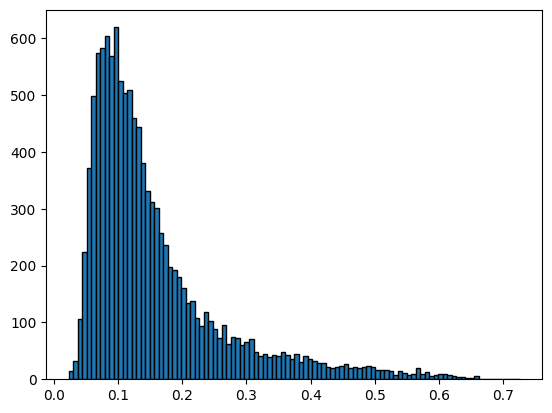

0.14608684


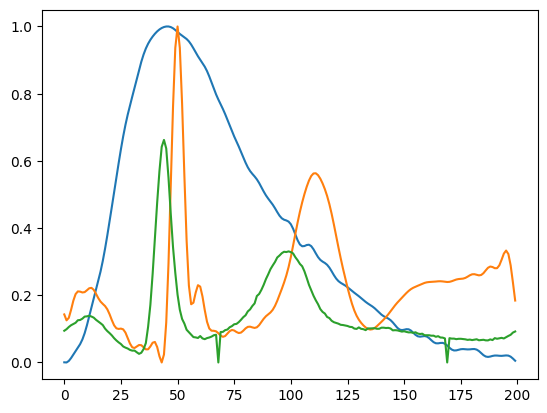

0.069841795


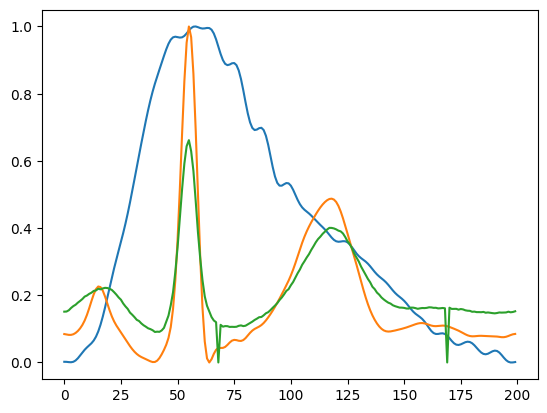

0.117775895


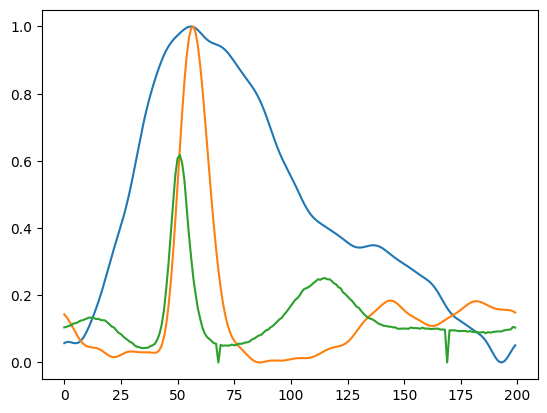

0.10272381


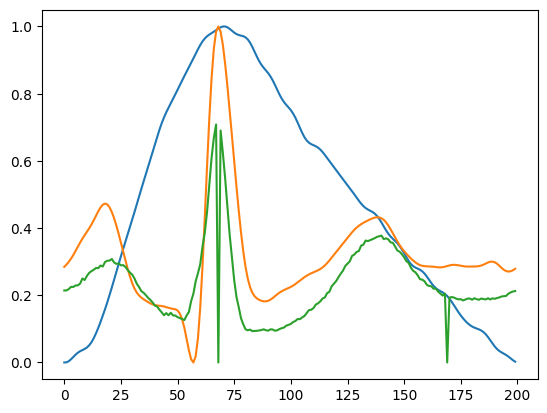

0.054385584


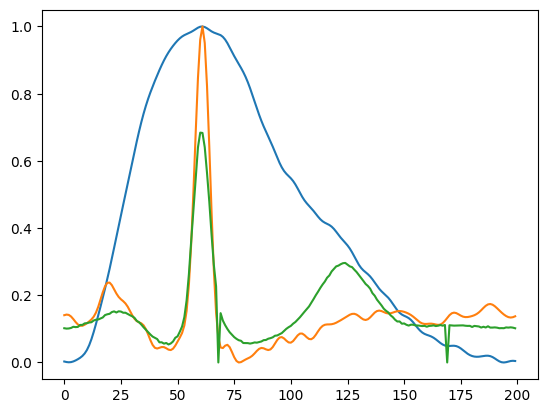

0.10571986


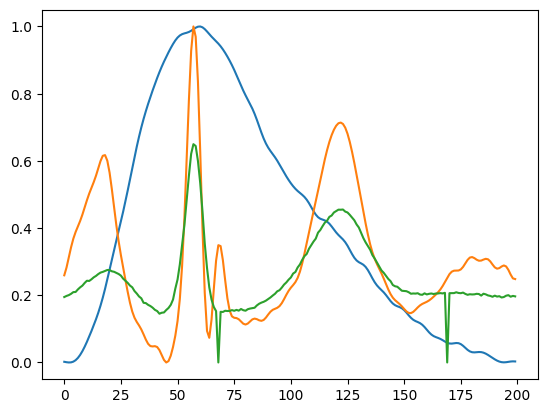

0.10764101


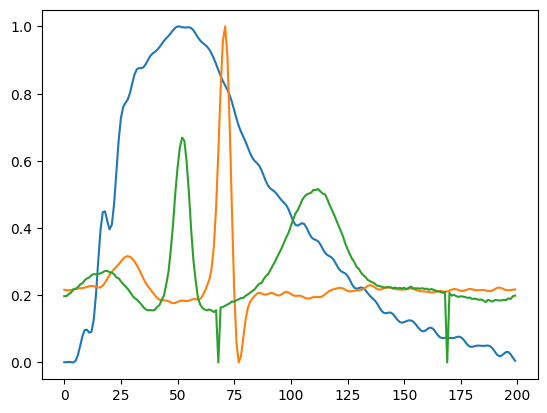

0.07492629


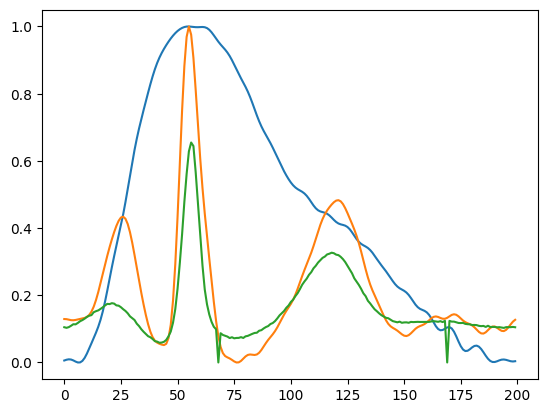

0.112725206


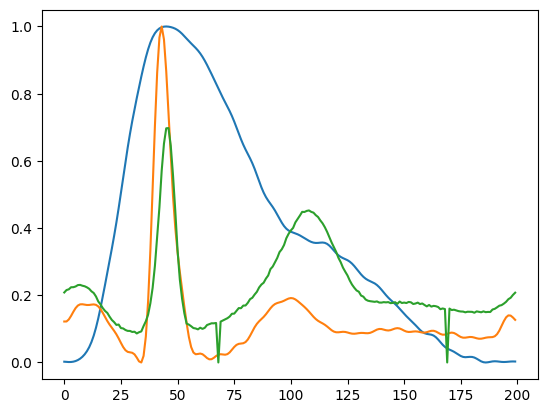

0.1483007


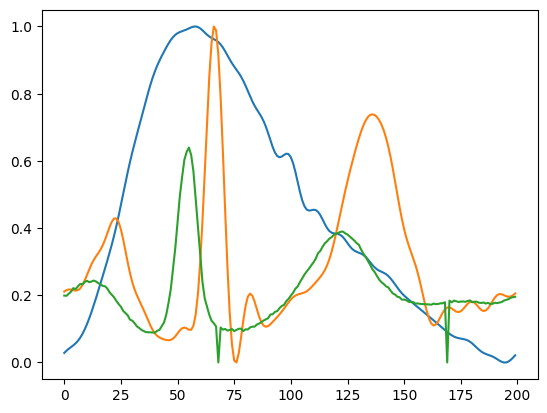

0.14845401


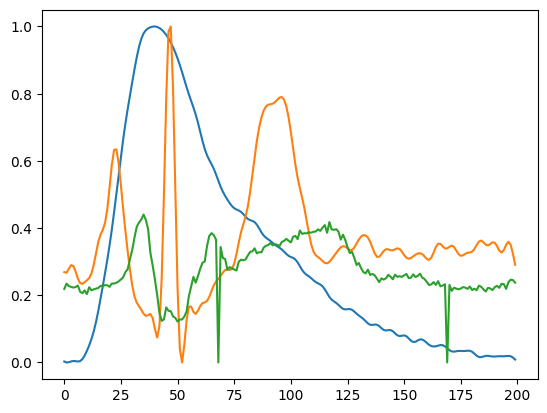

0.07084419


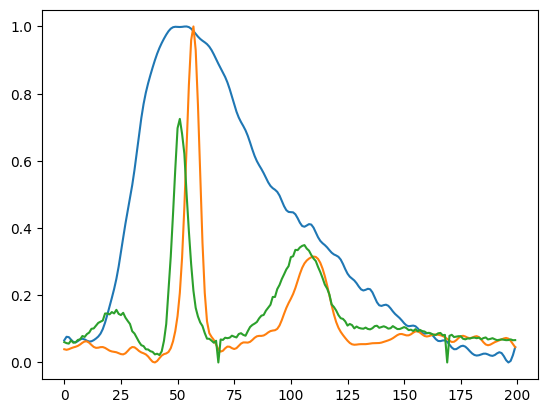

0.10483232


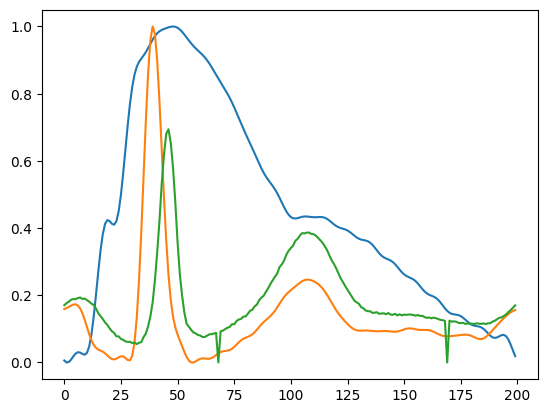

0.075363465


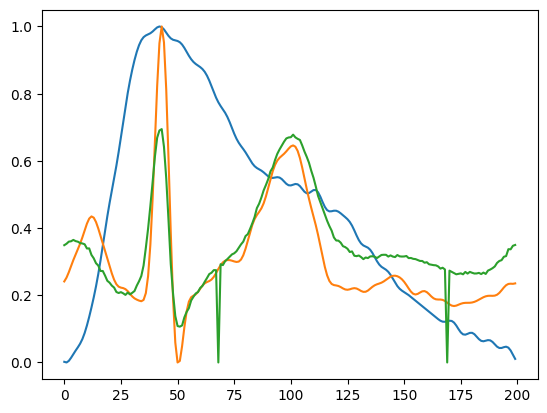

0.09429676


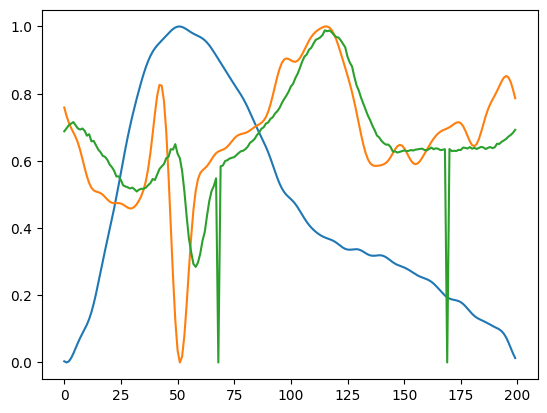

0.054215286


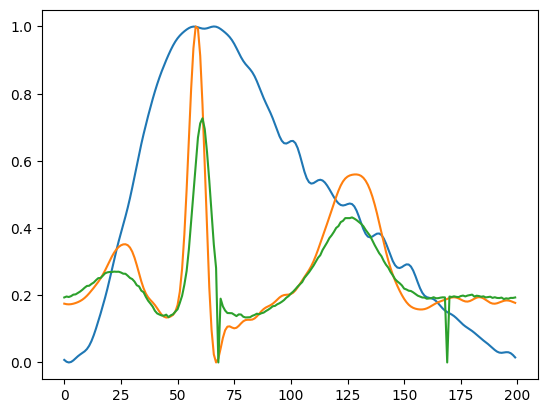

0.10078792


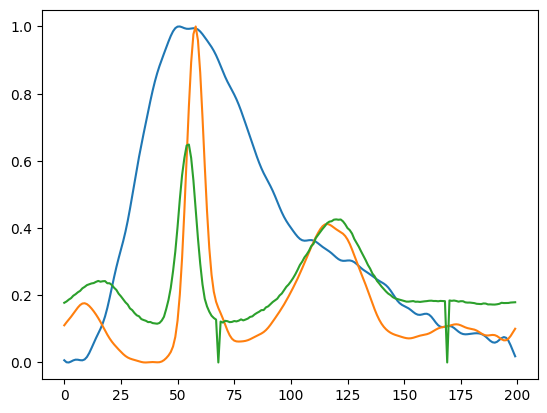

0.11966526


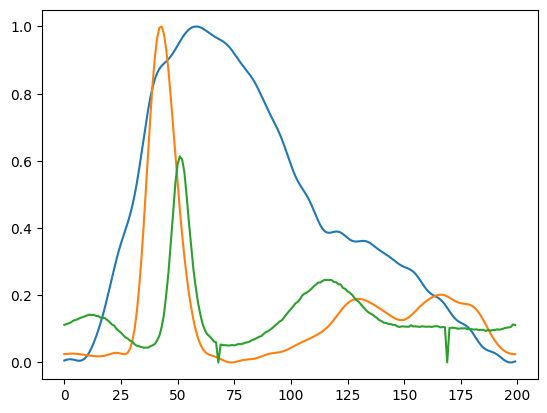

0.1026614


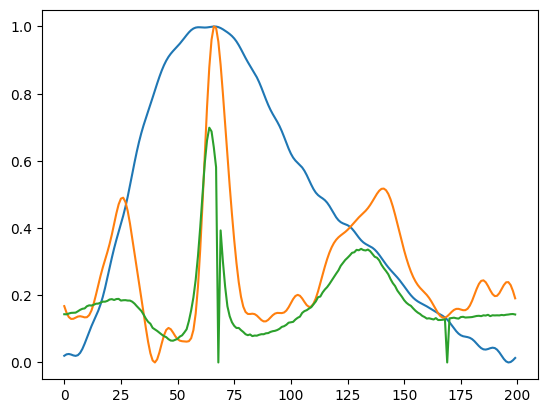

0.12937756


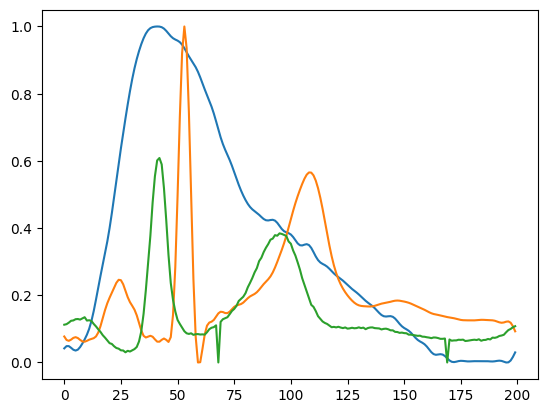

0.0979443


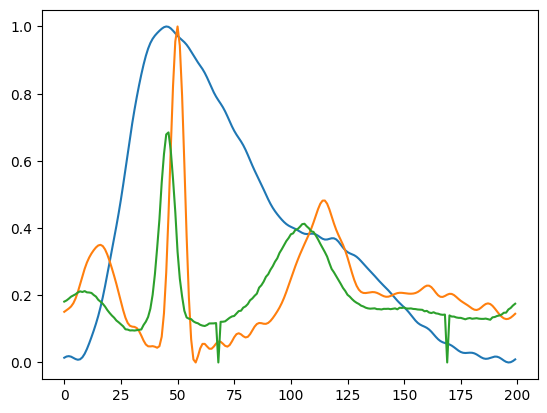

0.094239935


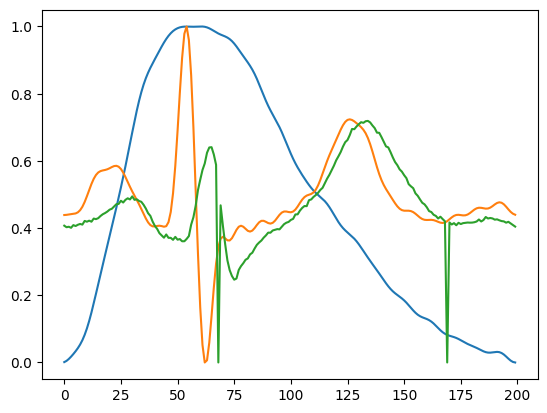

0.07760305


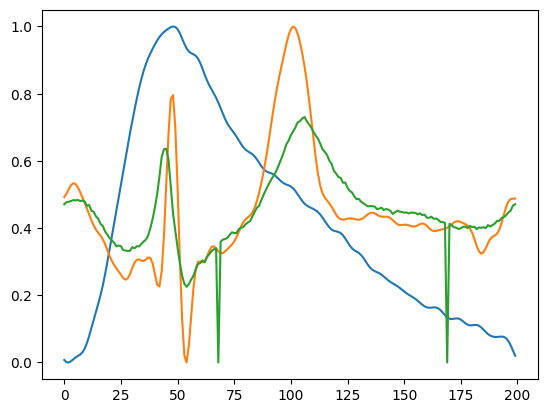

0.062095862


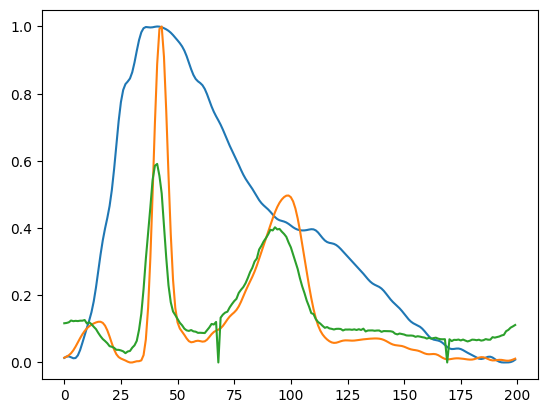

0.07325475


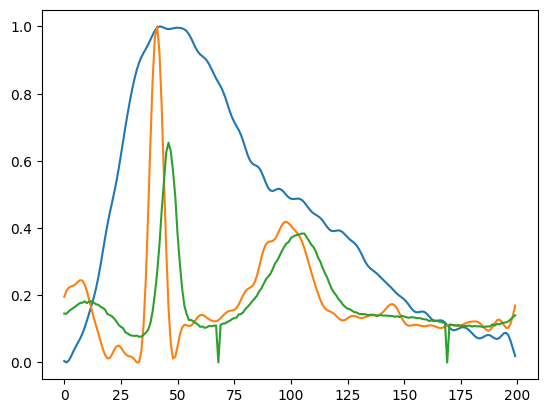

0.109615445


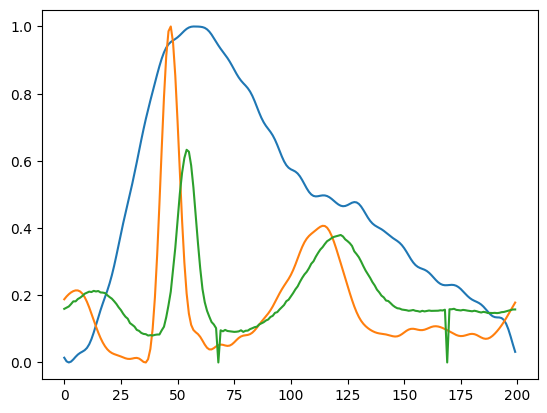

0.062725306


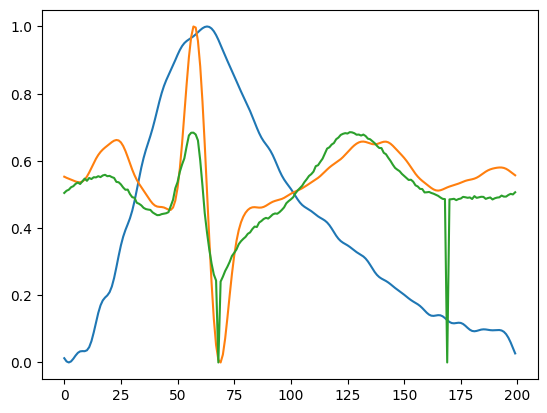

0.13792966


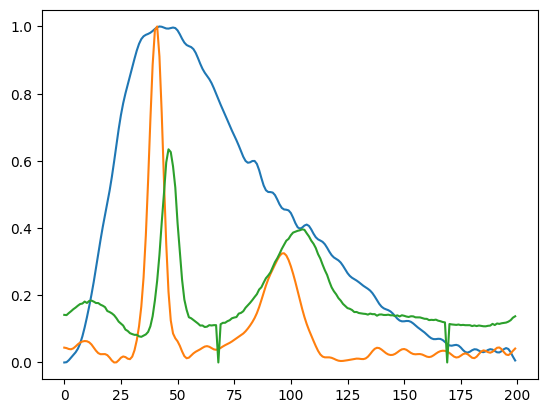

0.13217676


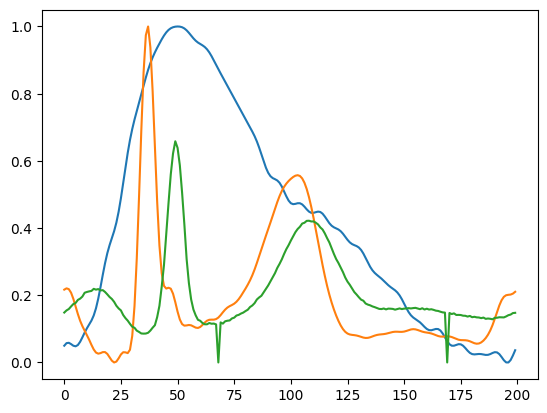

0.08909724


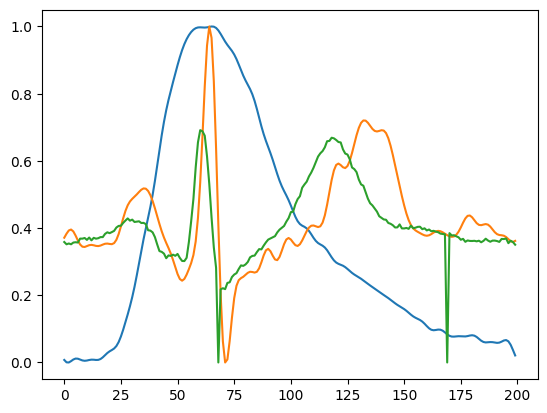

0.14787808


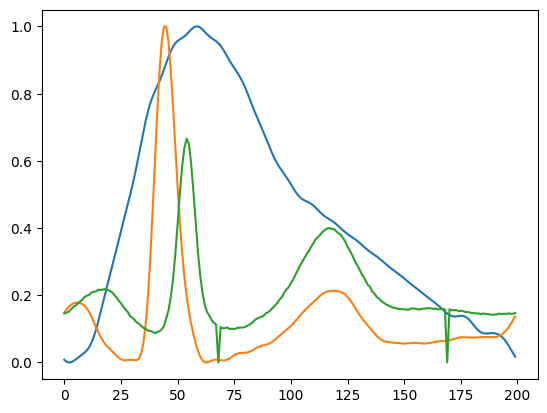

0.0763884


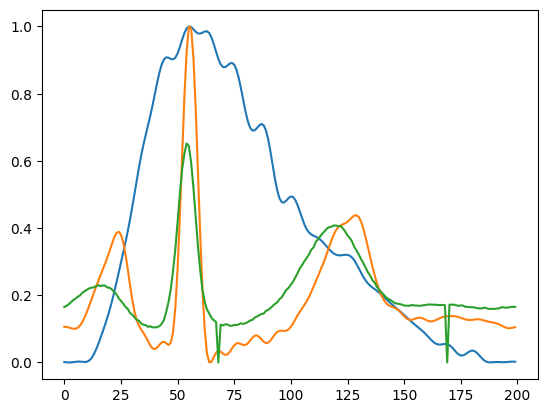

0.13622096


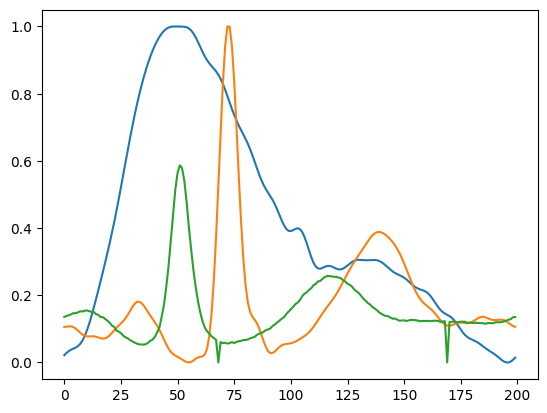

0.11763666


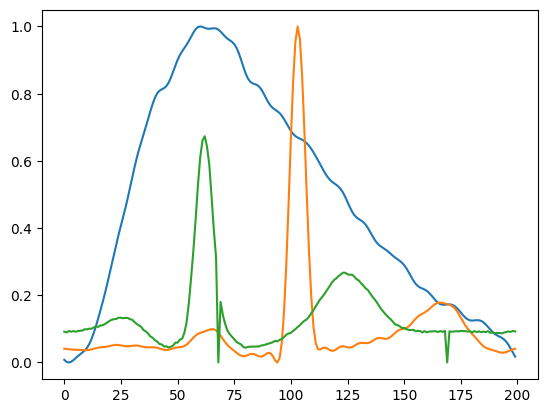

0.1333572


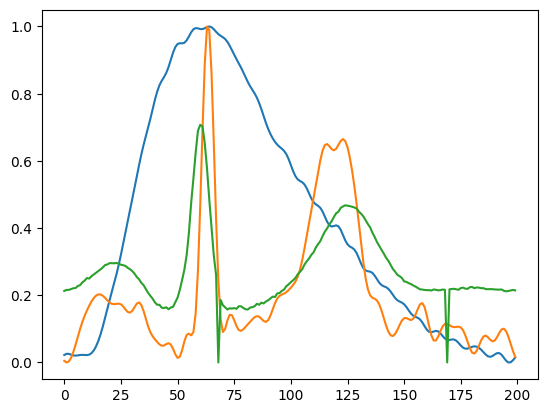

0.077743284


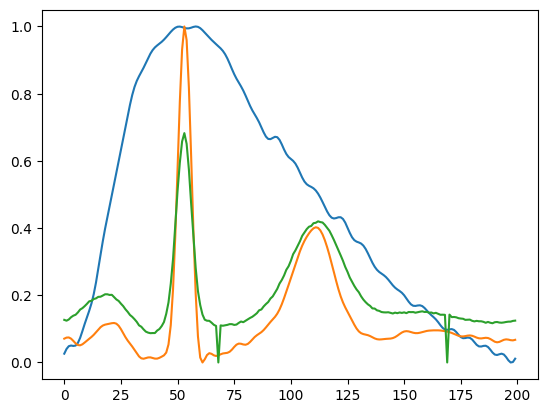

0.13846363


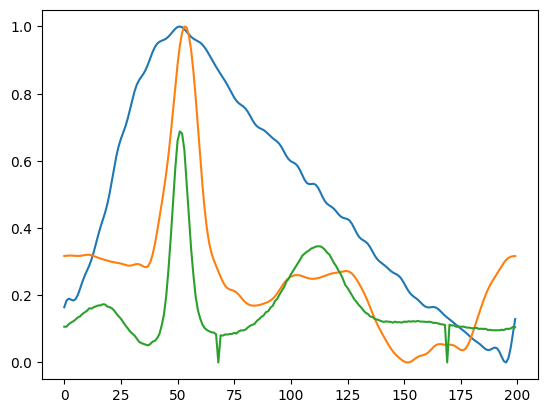

0.11027101


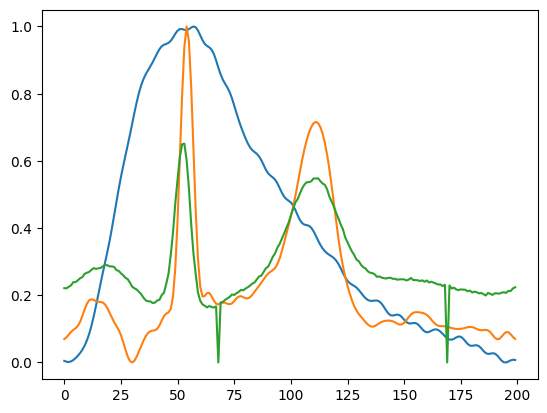

0.071176276


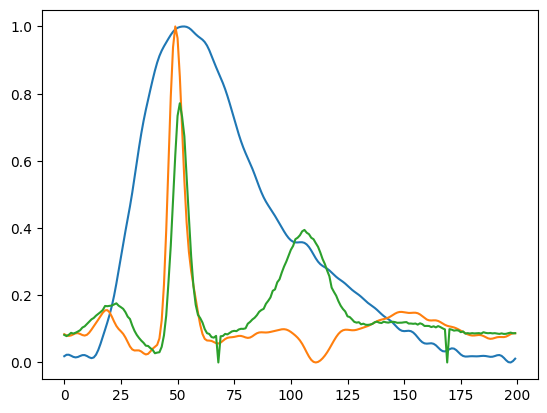

0.06534373


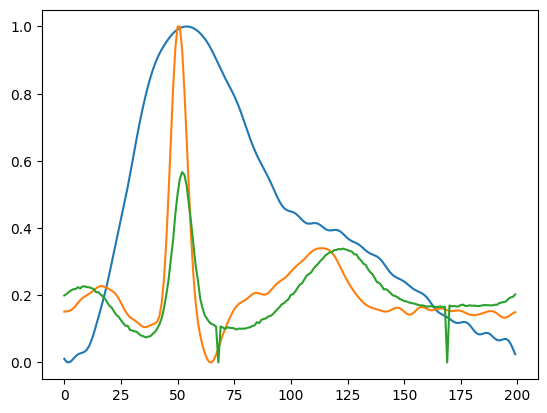

0.13331342


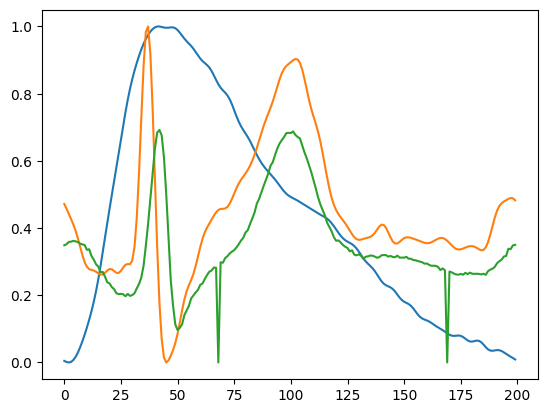

0.12990136


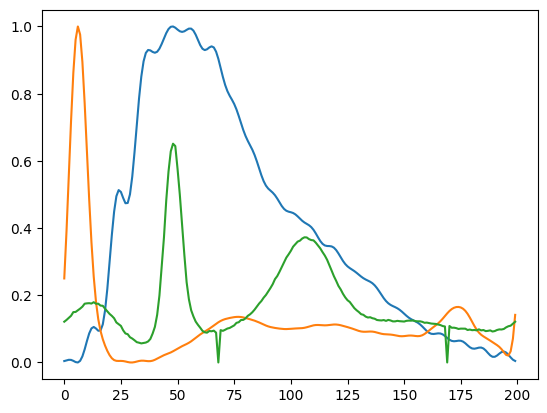

0.062503025


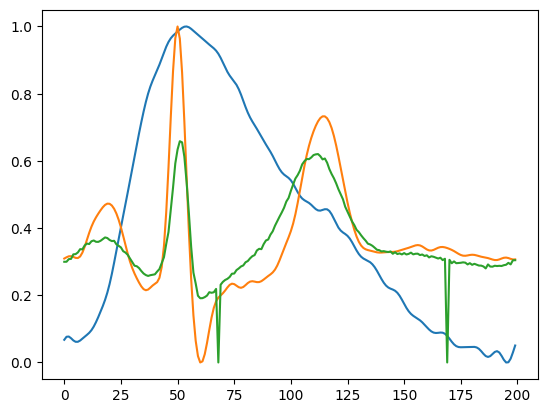

0.066082


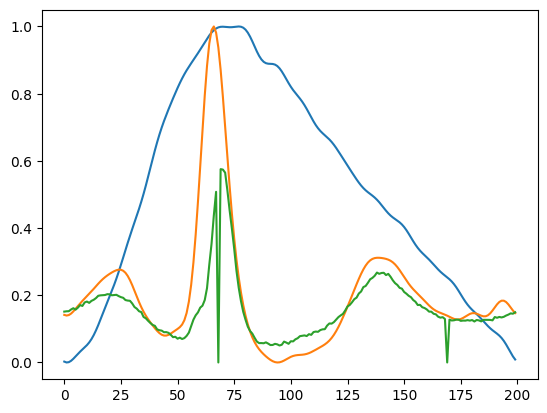

0.06410048


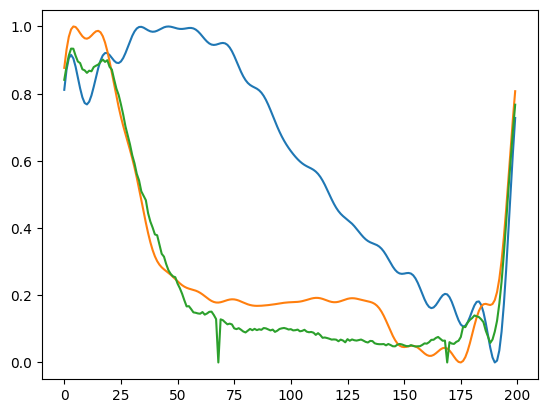

0.115548395


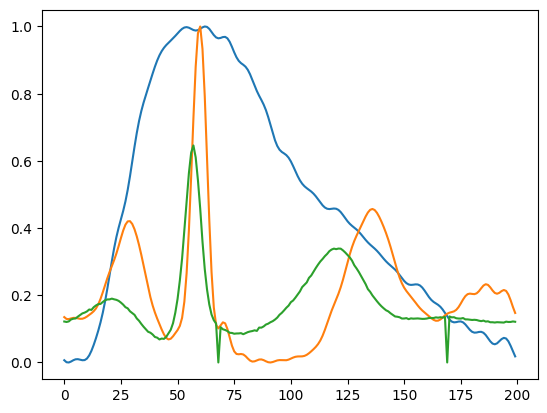

0.11036139


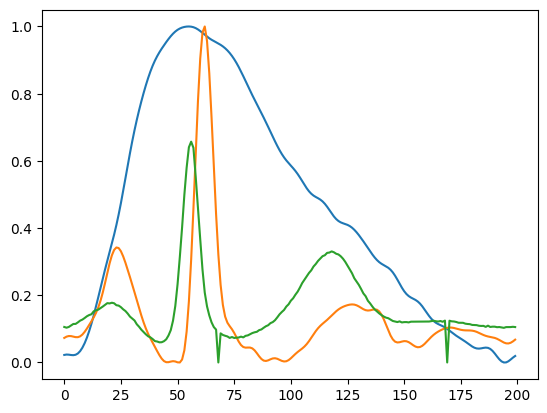

0.122843884


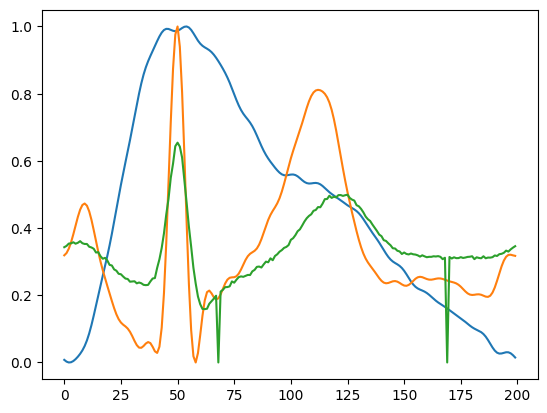

0.065193765


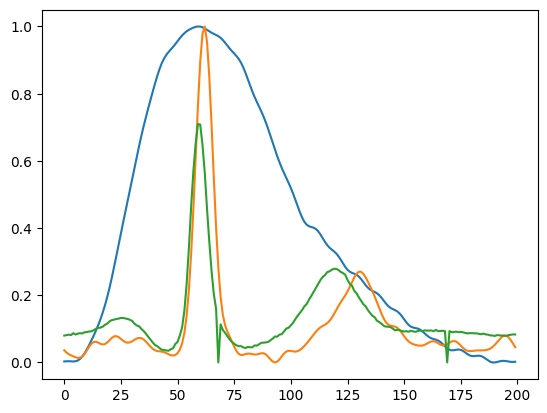

0.072831064


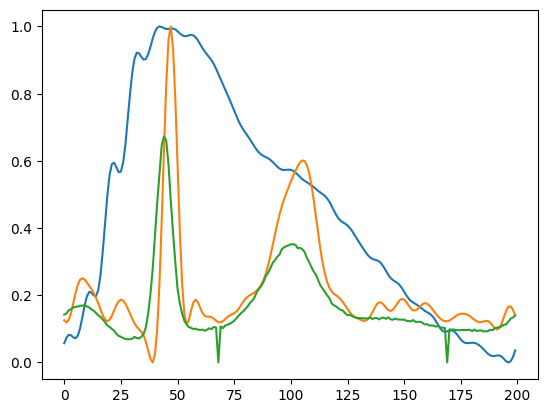

0.0520543


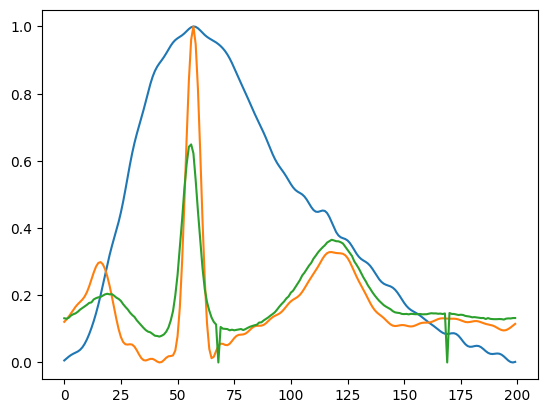

0.106110185


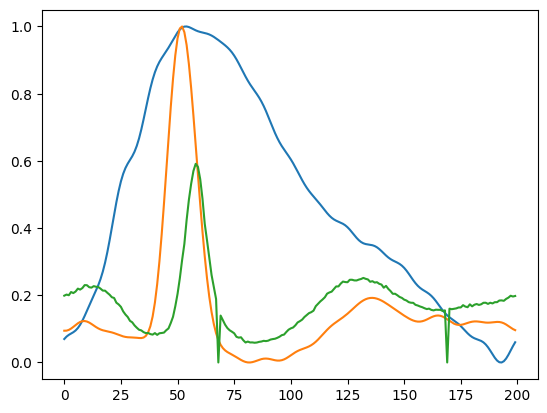

0.13725805


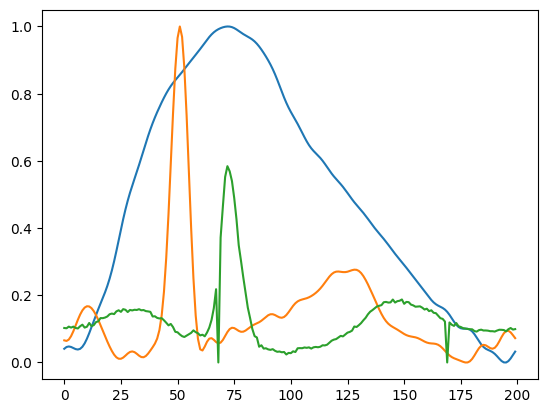

0.07123336


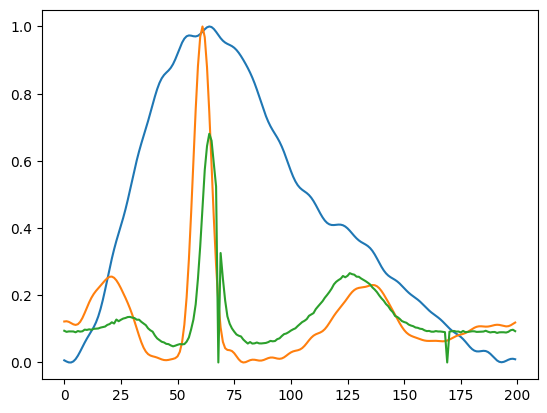

0.07134665


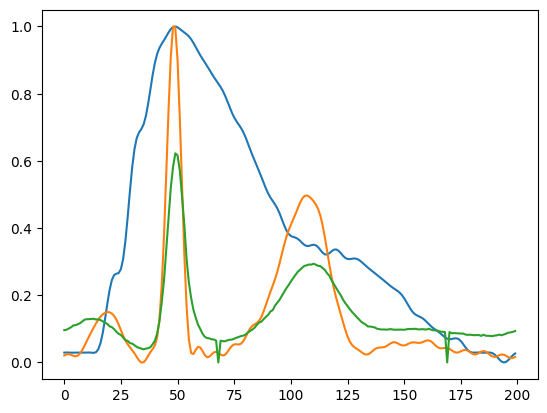

0.12258686


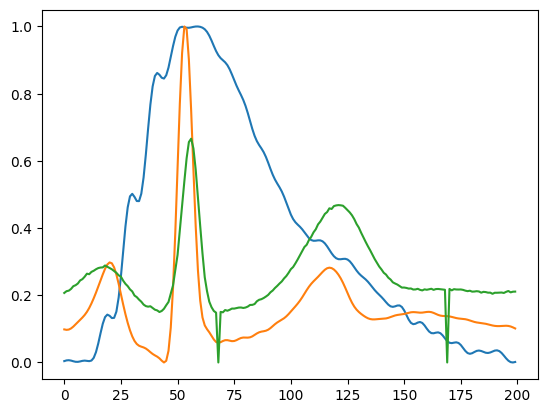

0.06503062


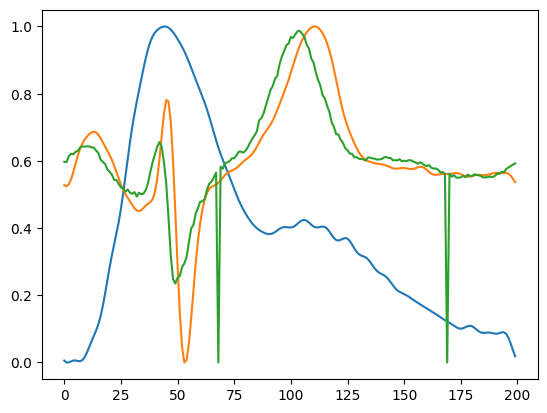

0.04454403


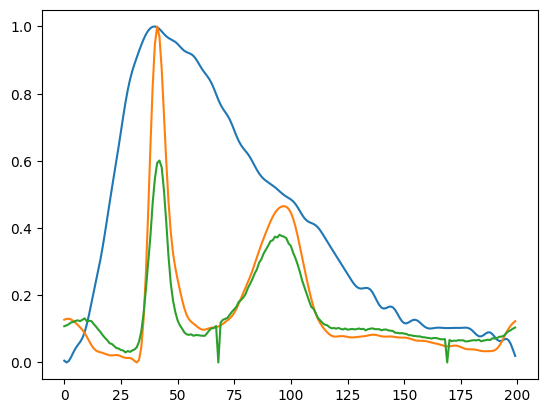

0.12996392


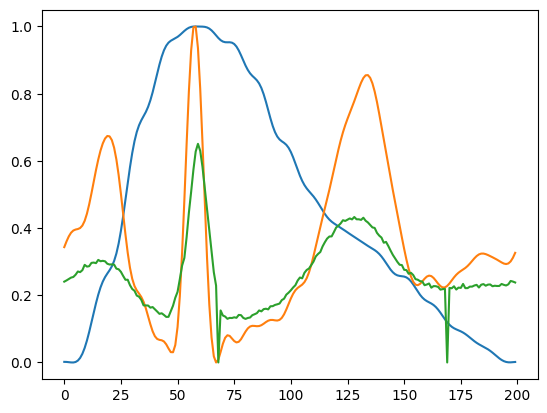

0.12135829


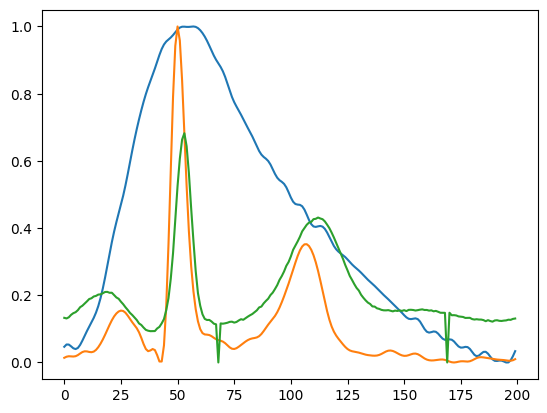

In [20]:
shower = performance()
shower.test(model,device,test_data,per_fnc = "series")
criterion = nn.L1Loss()
for i in range(100,200):
    y = test_data[i][1].numpy().flatten()
    y_hat = model.forward(test_data[i][0].to(device))
    loss = criterion(y_hat,test_data[i][1].to(device))
    if loss.cpu().detach().numpy() <0.15:
        print(loss.cpu().detach().numpy())
        plt.plot(test_data[i][0].to(device).cpu().detach().numpy().flatten())
        plt.plot(y)
        plt.plot(y_hat.cpu().detach().numpy().flatten())
        # plt.stem(model.hidden_layer.cpu().detach().numpy().flatten())
        plt.show()